In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load and normalize the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

full_train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
full_test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)


train_subset = Subset(full_train_dataset, torch.arange(5000))
test_subset = Subset(full_test_dataset, torch.arange(1000))

train_loader = DataLoader(train_subset, batch_size=60, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=60, shuffle=True)

100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:03<00:00, 3.30MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 52.8kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:07<00:00, 220kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.84MB/s]


In [3]:
# Define the model
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),  
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.network(x)

In [4]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=5):
    
    val_accuracies = []
    
    for epoch in range(epochs):
        # Training 
        model.train()
        for batch, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()          # Zero the gradients
            outputs = model(images)        # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward()                # Backpropagate
            optimizer.step()               # Update weights
            
            if batch%100 == 0:
                print(f"Epoch {epoch}, Batch: {batch}, Train Loss: {loss.item():0.2f}")
            
        
        # Evaluation
        model.eval()
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)
        
    return val_accuracies

In [5]:
# Instantiate the model, define loss function and optimizer
model = MNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

val_accuracies_no_bn = train_model(model, train_loader, test_loader, optimizer, criterion, 10)

Epoch 0, Batch: 0, Train Loss: 2.32
Epoch 1, Batch: 0, Train Loss: 0.49
Epoch 2, Batch: 0, Train Loss: 0.60
Epoch 3, Batch: 0, Train Loss: 0.30
Epoch 4, Batch: 0, Train Loss: 0.46
Epoch 5, Batch: 0, Train Loss: 0.25
Epoch 6, Batch: 0, Train Loss: 0.35
Epoch 7, Batch: 0, Train Loss: 0.15
Epoch 8, Batch: 0, Train Loss: 0.06
Epoch 9, Batch: 0, Train Loss: 0.23


In [6]:
print(val_accuracies_no_bn)

[0.835, 0.856, 0.86, 0.86, 0.888, 0.895, 0.889, 0.895, 0.892, 0.896]


WITH BATCH NORMALISATION

In [7]:
# Define the model
class MNISTClassifierWithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),  
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.network(x)

In [8]:
# Instantiate the model, define loss function and optimizer
model_with_bn = MNISTClassifierWithBN().to(device)
criterion_with_bn = nn.CrossEntropyLoss()
optimizer_with_bn = optim.Adam(model_with_bn.parameters(), lr=0.001)

val_accuracies_with_bn = train_model(model_with_bn, train_loader, test_loader, optimizer_with_bn, criterion_with_bn, 10)

Epoch 0, Batch: 0, Train Loss: 2.29
Epoch 1, Batch: 0, Train Loss: 0.45
Epoch 2, Batch: 0, Train Loss: 0.12
Epoch 3, Batch: 0, Train Loss: 0.12
Epoch 4, Batch: 0, Train Loss: 0.07
Epoch 5, Batch: 0, Train Loss: 0.11
Epoch 6, Batch: 0, Train Loss: 0.02
Epoch 7, Batch: 0, Train Loss: 0.02
Epoch 8, Batch: 0, Train Loss: 0.02
Epoch 9, Batch: 0, Train Loss: 0.02


In [9]:
val_accuracies_with_bn

[0.882, 0.902, 0.922, 0.918, 0.932, 0.942, 0.934, 0.93, 0.943, 0.935]

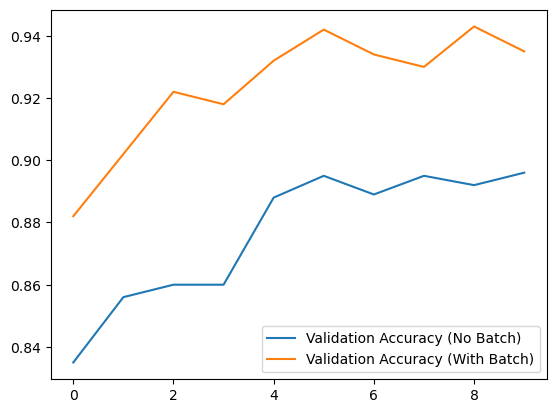

In [10]:
plt.plot(val_accuracies_no_bn, label="Validation Accuracy (No Batch)")
plt.plot(val_accuracies_with_bn, label="Validation Accuracy (With Batch)")
plt.legend()
plt.show()